In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, curve_fit
from scipy.linalg import expm
from scipy.linalg import eig
import scipy.linalg
import matplotlib.pyplot as plt
import control as ct
import cvxpy as cp
import casadi as ca

import Modified_FourTank_functions as fun   # Import functions
from Modified_FourTank_parameters import p, a1, a2, a3, a4, A1, A2, A3, A4, g, gamma1, gamma2, rho  # Import parameters

Modified 4tank system

# Problem 2
Deterministic and Stochastic Nonlinear Modeling

## 2.1 Deterministic Nonlinear Model

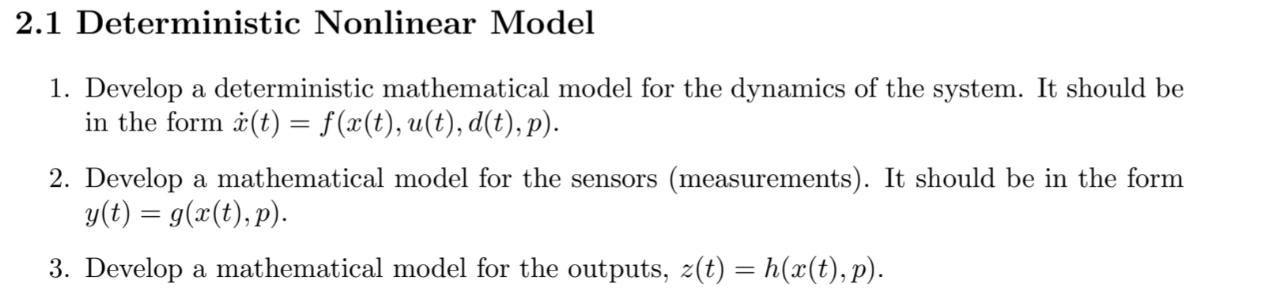

See "Modified_FourTanksystem" function

See "FourTankSystemSensor_Deterministic" function

See "FourTankSystemOutput" function

- What is the difference on sensor and output? and should we use level or mass?


## 2.2 Stochastic Nonlinear Model

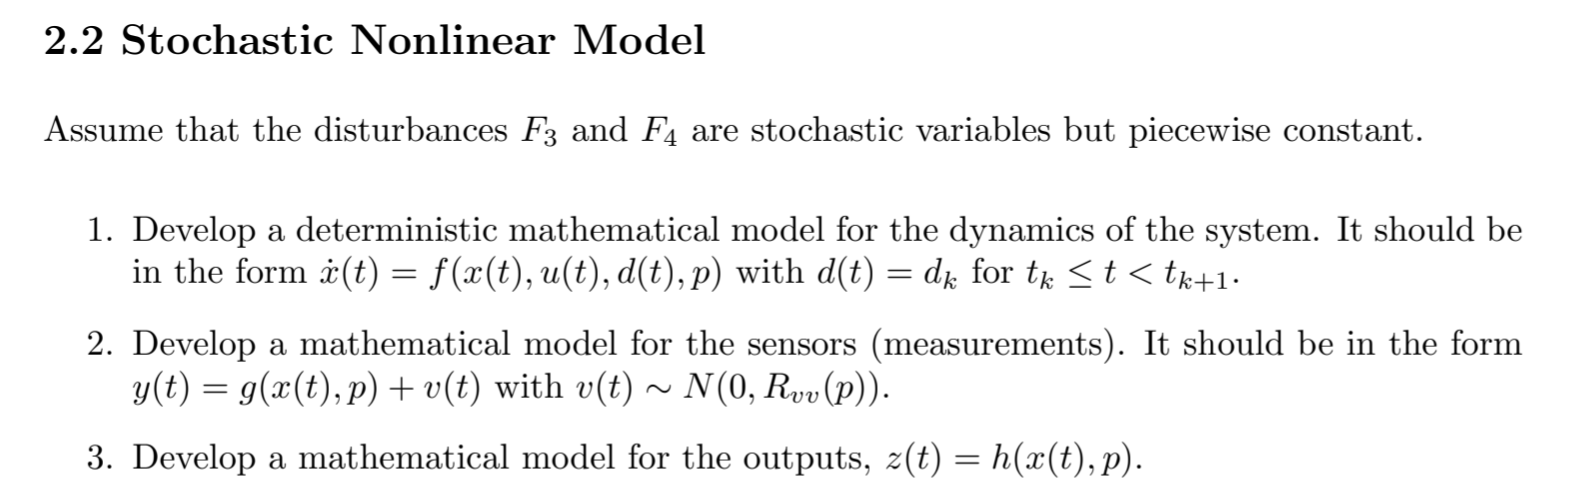

1. See "run_step" function
2. See "FourTankSystemSensor" function
3. See "FourTankSystemOutput" function

## 2.3 Stochastic Nonlinear Model (SDE)

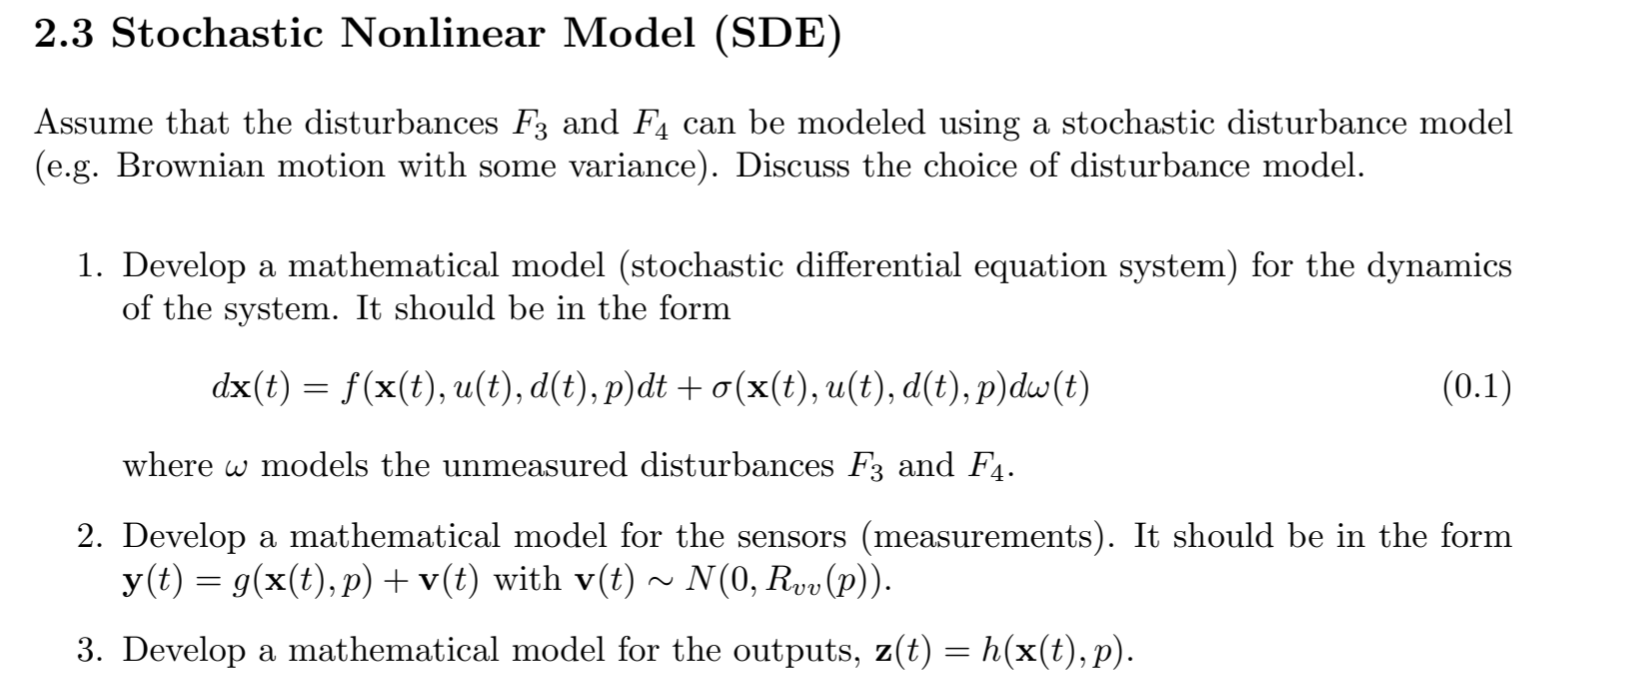

$$
dm_1 = \rho(q_{1in} + q_3 - q_1)dt
$$
$$
dm_2 = \rho(q_{2in} + q_4 - q_2)dt
$$
$$
dm_3 = \rho(q_{3in} - q_3 + \bar{F_3})dt + \sigma_3 d\omega
$$
$$
dm_4 = \rho(q_{4in} - q_4 + \bar{F_4})dt + \sigma_4 d\omega
$$

## 2.4 Simulation

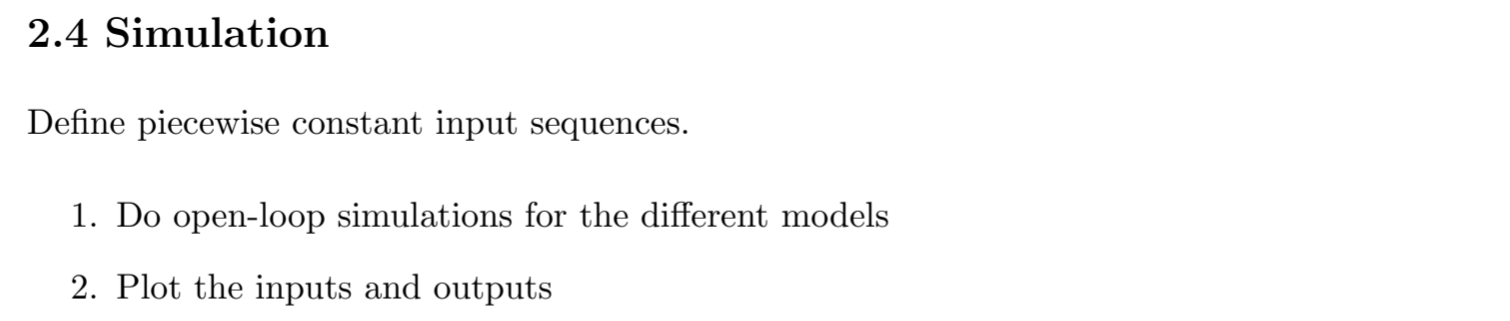

### For model 2.2

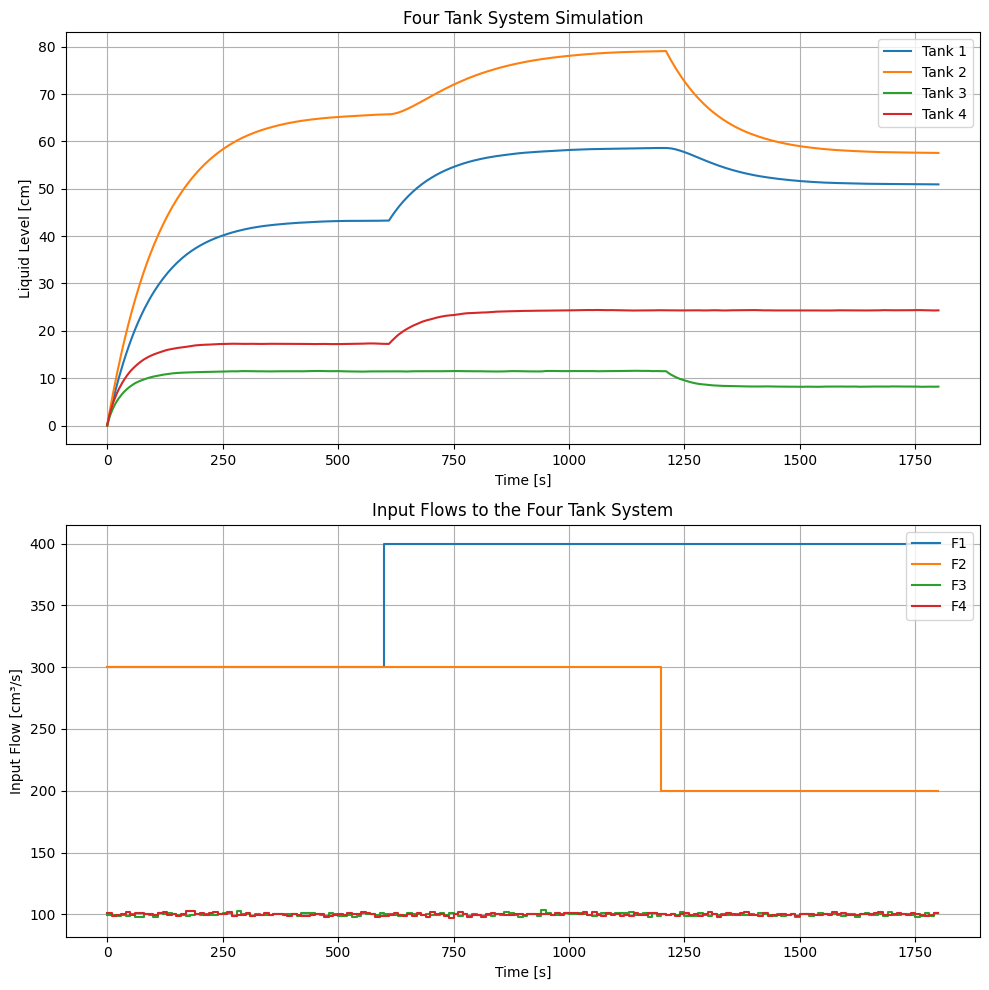

In [2]:
# Initial liquid levels [cm]
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
# Convert levels to mass [g] => m = rho * A * h
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40

x0 = np.array([m10, m20, m30, m40])  # Initial states
times = np.array([0,10,20,30])*60 # start and end of each interval
dt = 10 # time stepping
N = len(times)  # number of intervals
nx = len(x0)
F1 = np.array([300,400,400])
F2 = np.array([300,300,200])
F3 = np.array([100,100,100])
F4 = np.array([100,100,100])
u = np.array([F1,F2])
d = np.array([F3,F4])

x, y, z, T_all, X_all, H_all = fun.sim22(times, x0, u, d, p, dt, noise_level=1)


### For model 2.3 (still need plot of disturbance with noise)

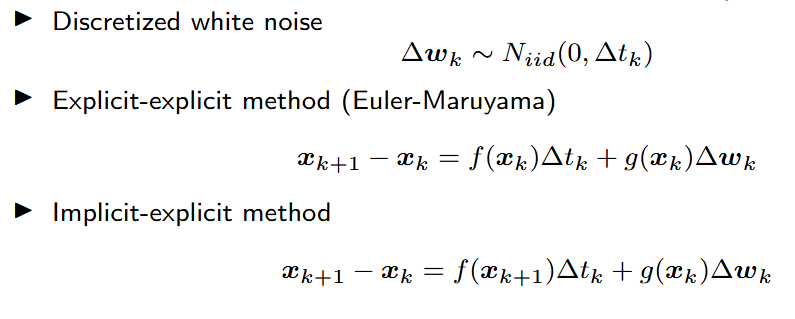

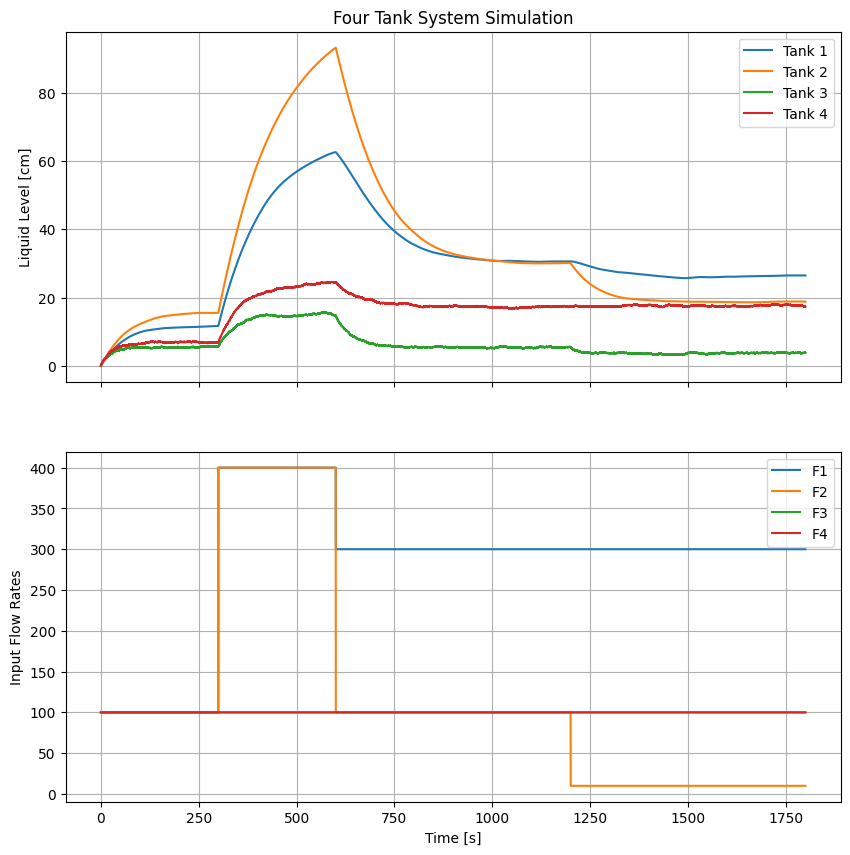

In [3]:
# --- Time and Noise Setup ---
times = np.array([0, 5, 10, 20, 30]) * 60  # in seconds
dt = 0.01

# --- Initial Conditions ---
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40
x0 = np.array([m10, m20, m30, m40])

# --- Input Profiles ---
F1 = np.array([100,400,300,300])
F2 = np.array([100,400,100,10])
F3 = np.array([100, 100, 100, 100])
F4 = np.array([100, 100, 100, 100])
u = np.array([F1, F2])
d = np.array([F3, F4])

x = fun.sim23(times, dt, x0, u, d, p, noise_level=20)

# Problem 3

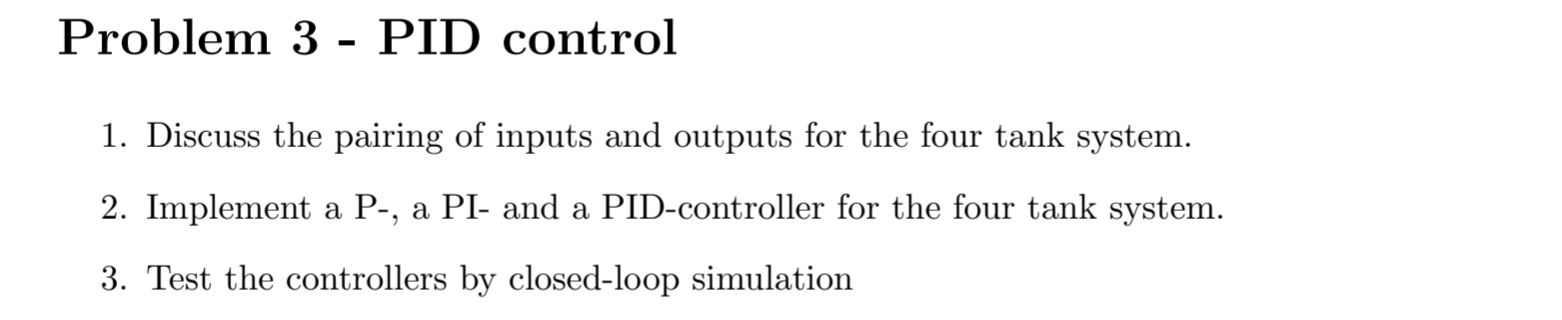

For controllers, steady state input need be known:
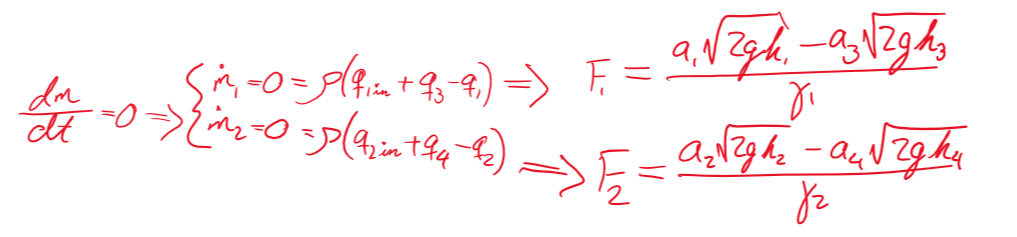

## For model 2.2
Kc is restricted by dt. Solver cannot handle if dt and Kc is too large.

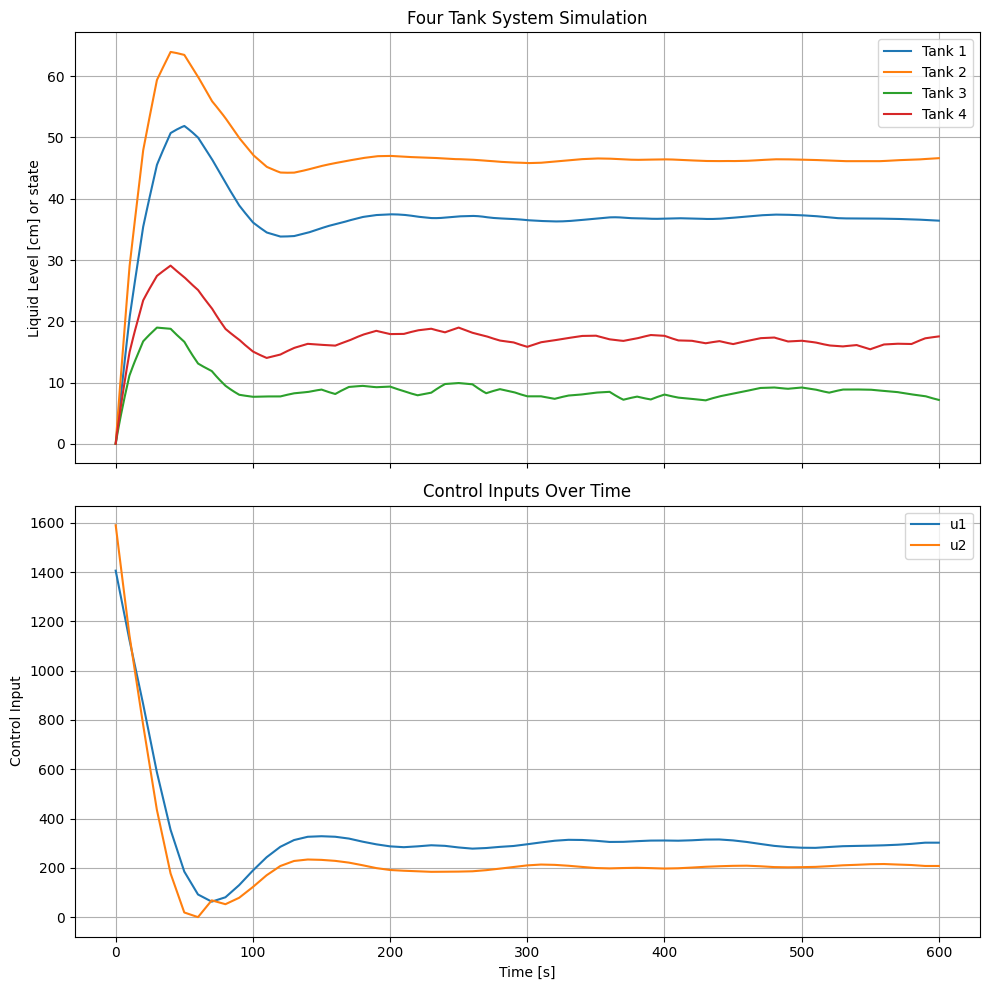

[36.42496803 46.62552393  7.16775765 17.53249949]
[302.03894336 207.55297258]


In [4]:
dt = 10   # update every 10sek
t_stop = 10*60
t = np.arange(0,t_stop+dt,dt)
N = len(t)
#F1, F2 = 300, 300
u0 = np.array([0,0])
d = 100*np.ones([2,N-1])
r = np.array([36.85514999, 46.33122105,  8.23605997, 17.28570838])  # set point (steady state when input is [300,200,100,100])
#r = np.array([17.90248217, 24.66734099,  1.06132002,  5.37293261]) # set point (steady state when input is [300,200,0,0])
#u[:,0] = F1,F2

us = fun.compute_steady_state_pump_flow(r,p)

T_all, X_all, H_all, u, y, z = fun.closed_loop_sim22(t, x0, u0, d, p, us, r, controller=fun.PIDcontroller, noise_level=20, Kc=10,Ki=1,Kd=100)

print(z[:,-1])
print(u[:,-1])

## For model 2.3

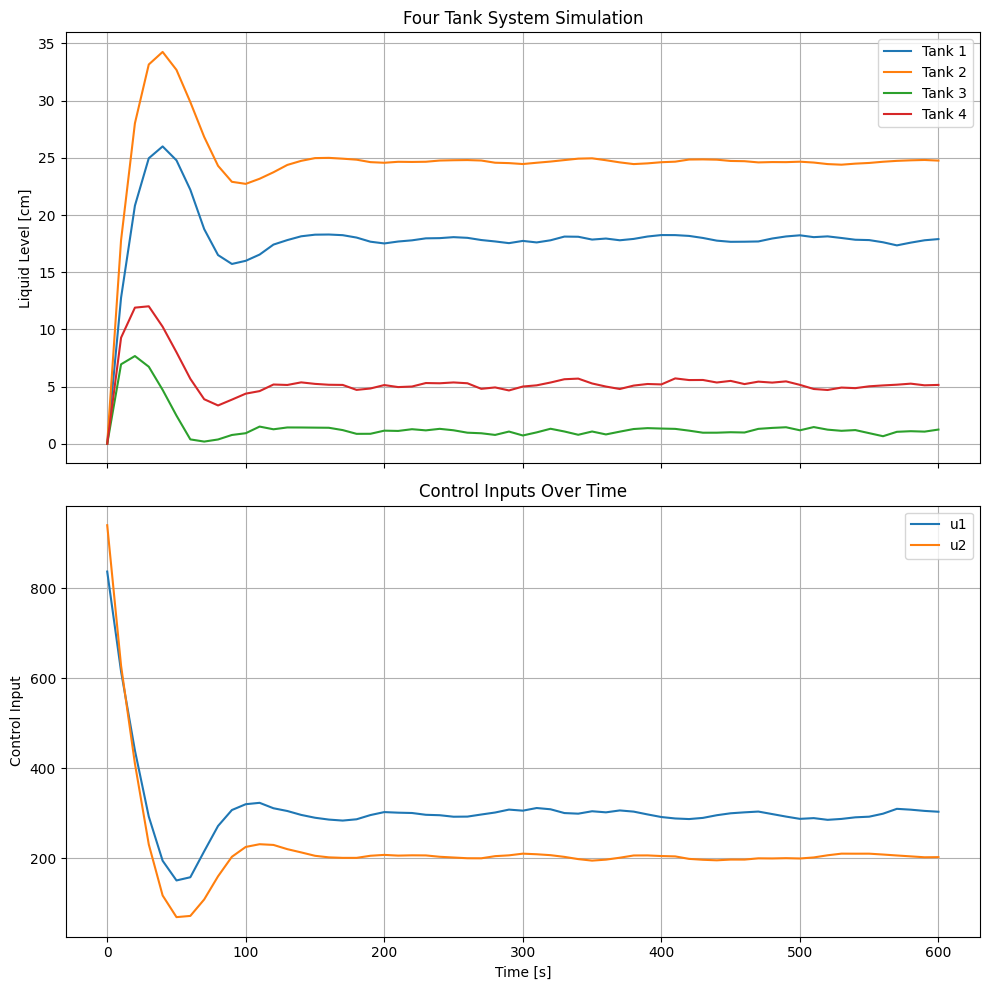

[17.89555734 24.75340845  1.24762842  5.15019326]
[303.47219254 202.59463094]


In [5]:
dt = 10   # update every 10sek
t_stop = 10*60
t = np.arange(0,t_stop+dt,dt)
N = len(t)
#F1, F2 = 300, 300
u0 = np.array([0,0])
d = np.zeros([2,N-1])

r = np.array([17.90248217, 24.66734099,  1.06132002,  5.37293261]) # set point (steady state when input is [300,200,0,0])
#u[:,0] = F1,F2

us = fun.compute_steady_state_pump_flow(r,p)

x, y, z, u = fun.closed_loop_sim23(t, x0, u0, d, p, us, r, controller=fun.PIDcontroller, noise_level=20, Kc=10,Ki=1,Kd=100)
print(z[:,-1])
print(u[:,-1])

# Problem 4
Nonlinear Simulation - Step Responses

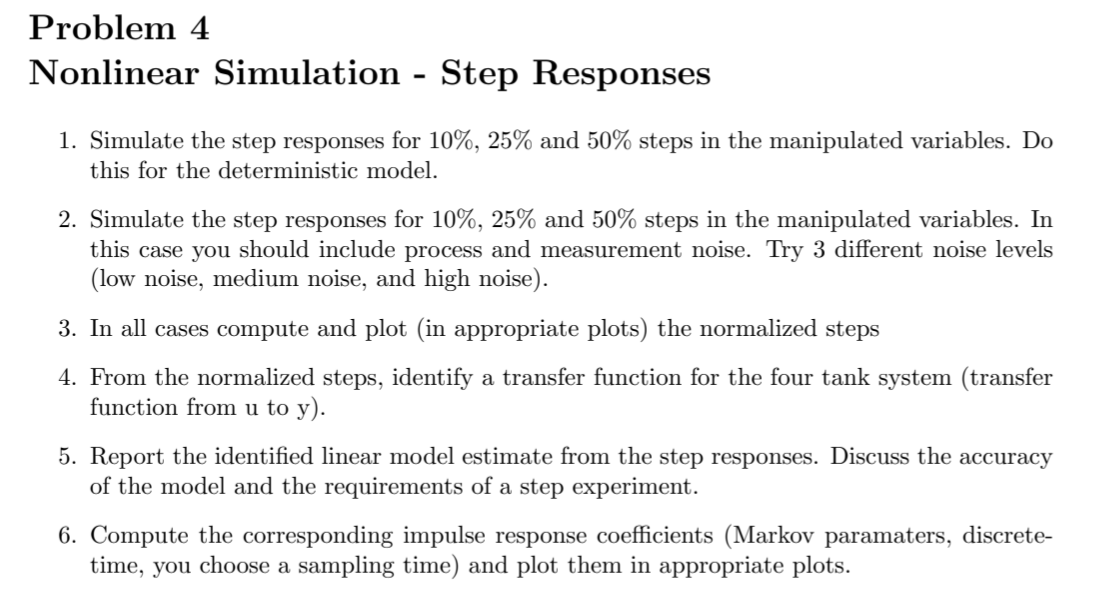

## For model 2.2 deterministic

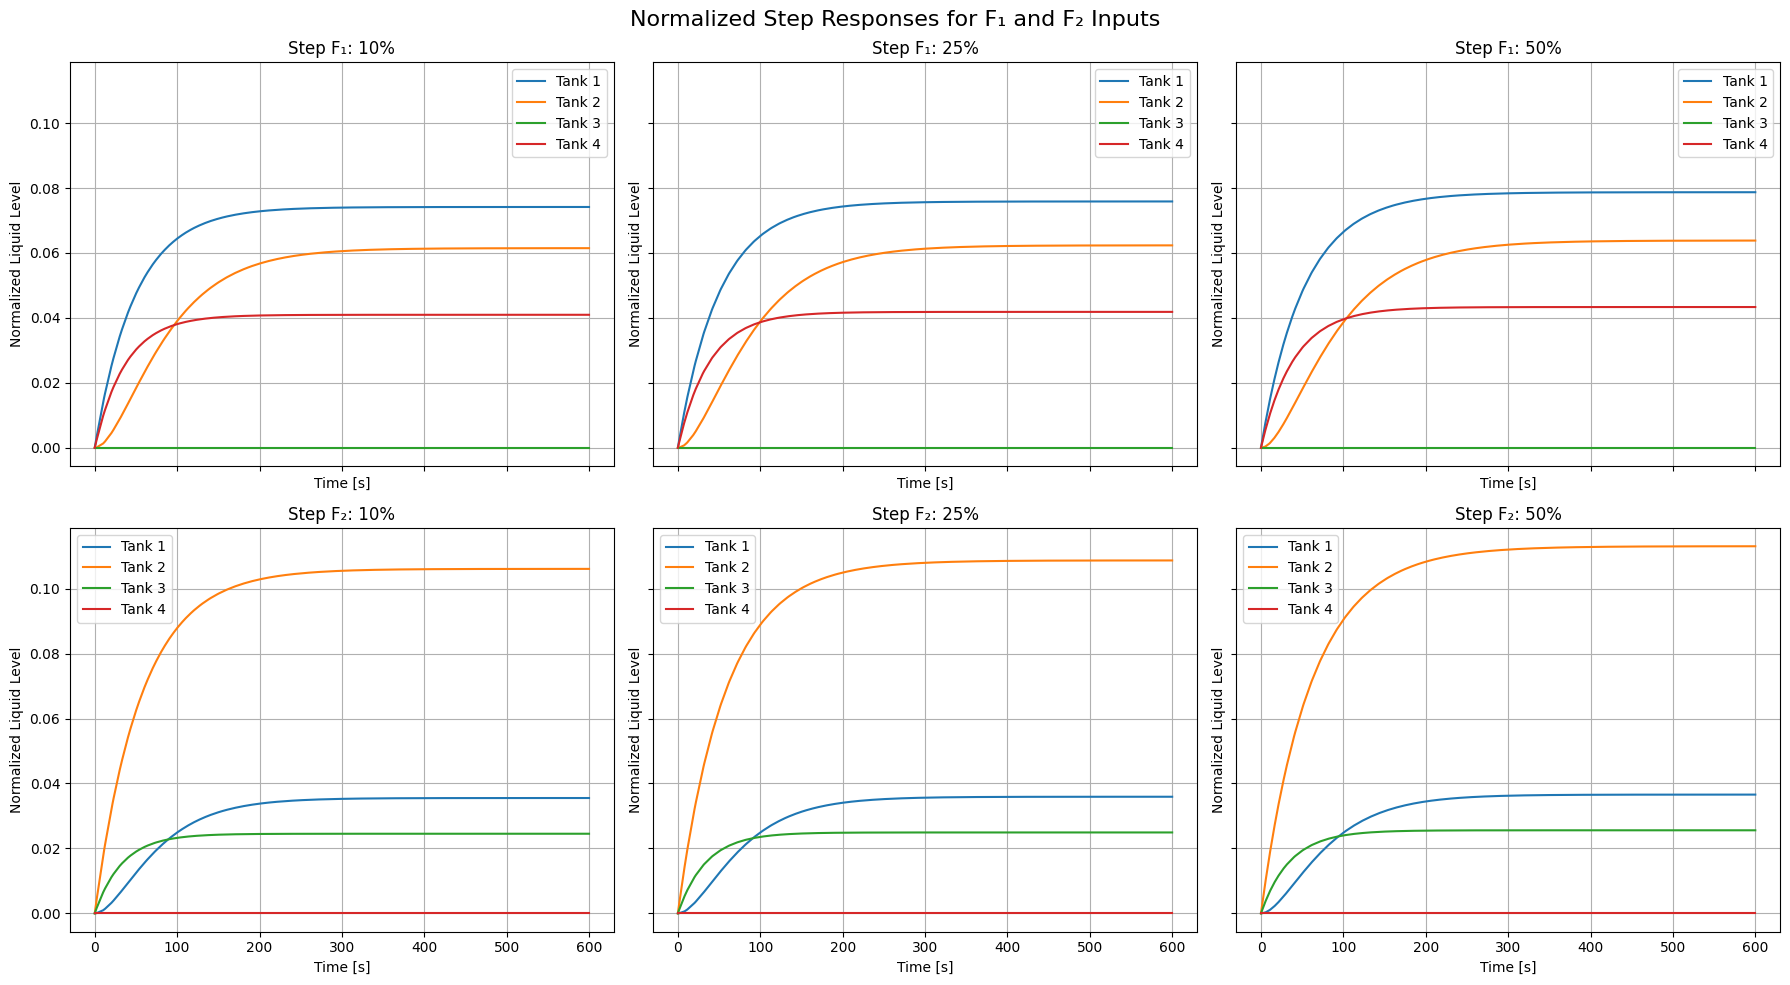

In [6]:
noise_level=0   # change for stochastic models
# Initial liquid levels [cm]
h10, h20, h30, h40 = 0.0, 0.0, 0.0, 0.0 # heights
# Convert levels to mass [g] => m = rho * A * h
m10 = rho * A1 * h10
m20 = rho * A2 * h20
m30 = rho * A3 * h30
m40 = rho * A4 * h40

x0 = np.array([m10, m20, m30, m40])  # Initial states for first simulation
dt = 10
step_pers_list = [0.1, 0.25, 0.5]
results_F1 = []
results_F2 = []

fig, axs = plt.subplots(2, len(step_pers_list), figsize=(18, 10), sharex=True, sharey=True)

for idx, step_pers in enumerate(step_pers_list):
    # --- Common setup ---
    F1_old = np.array([100])
    F2_old = np.array([100])
    F3_old = np.array([100])
    F4_old = np.array([100])
    A = p[4:8]
    rho = p[11]
    times = np.array([0,10])*60
    tf = times[-1]
    t = np.arange(0, tf + dt, dt)

    # --- Steady-state simulation ---
    u = np.array([F1_old, F2_old])
    d = np.array([F3_old, F4_old])
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0, u, d, p, dt, noise_level=noise_level, plot=False)
    x0_ss = X_all[-1,:].flatten()
    h0_ss = H_all[-1,:].flatten()

    # ============================
    # Simulation: Step in F1 only
    # ============================
    F1 = F1_old * (1 + step_pers)
    F2 = F2_old
    u = np.array([F1, F2])
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0_ss, u, d, p, dt, noise_level=noise_level, plot=False)
    results_F1.append(x)
    h_end = H_all[-1,:].flatten()
    step_size_F1 = float(F1[0] - F1_old[0])

    # --- Plot F1 step response ---
    for i in range(4):
        axs[0, idx].plot(T_all.flatten(), (H_all[:, i] - h0_ss[i]) / step_size_F1, label=f'Tank {i+1}')
    axs[0, idx].set_title(f'Step F₁: {int(step_pers*100)}%')
    axs[0, idx].set_xlabel('Time [s]')
    axs[0, idx].grid(True)

    # ============================
    # Simulation: Step in F2 only
    # ============================
    F1 = F1_old
    F2 = F2_old * (1 + step_pers)
    u = np.array([F1, F2])
    x, y, z, T_all, X_all, H_all = fun.sim22(times, x0_ss, u, d, p, dt, noise_level=noise_level, plot=False)
    results_F2.append(x)
    h_end = H_all[-1,:].flatten()
    step_size_F2 = float(F2[0] - F2_old[0])

    # --- Plot F2 step response ---
    for i in range(4):
        axs[1, idx].plot(T_all.flatten(), (H_all[:, i] - h0_ss[i]) / step_size_F2, label=f'Tank {i+1}')
    axs[1, idx].set_title(f'Step F₂: {int(step_pers*100)}%')
    axs[1, idx].set_xlabel('Time [s]')
    axs[1, idx].grid(True)

# --- Final plot formatting ---
for row in axs:
    for ax in row:
        ax.set_ylabel('Normalized Liquid Level')
        ax.legend()

fig.suptitle('Normalized Step Responses for F₁ and F₂ Inputs', fontsize=16)
plt.tight_layout()
plt.show()

## For model 2.3 deterministic

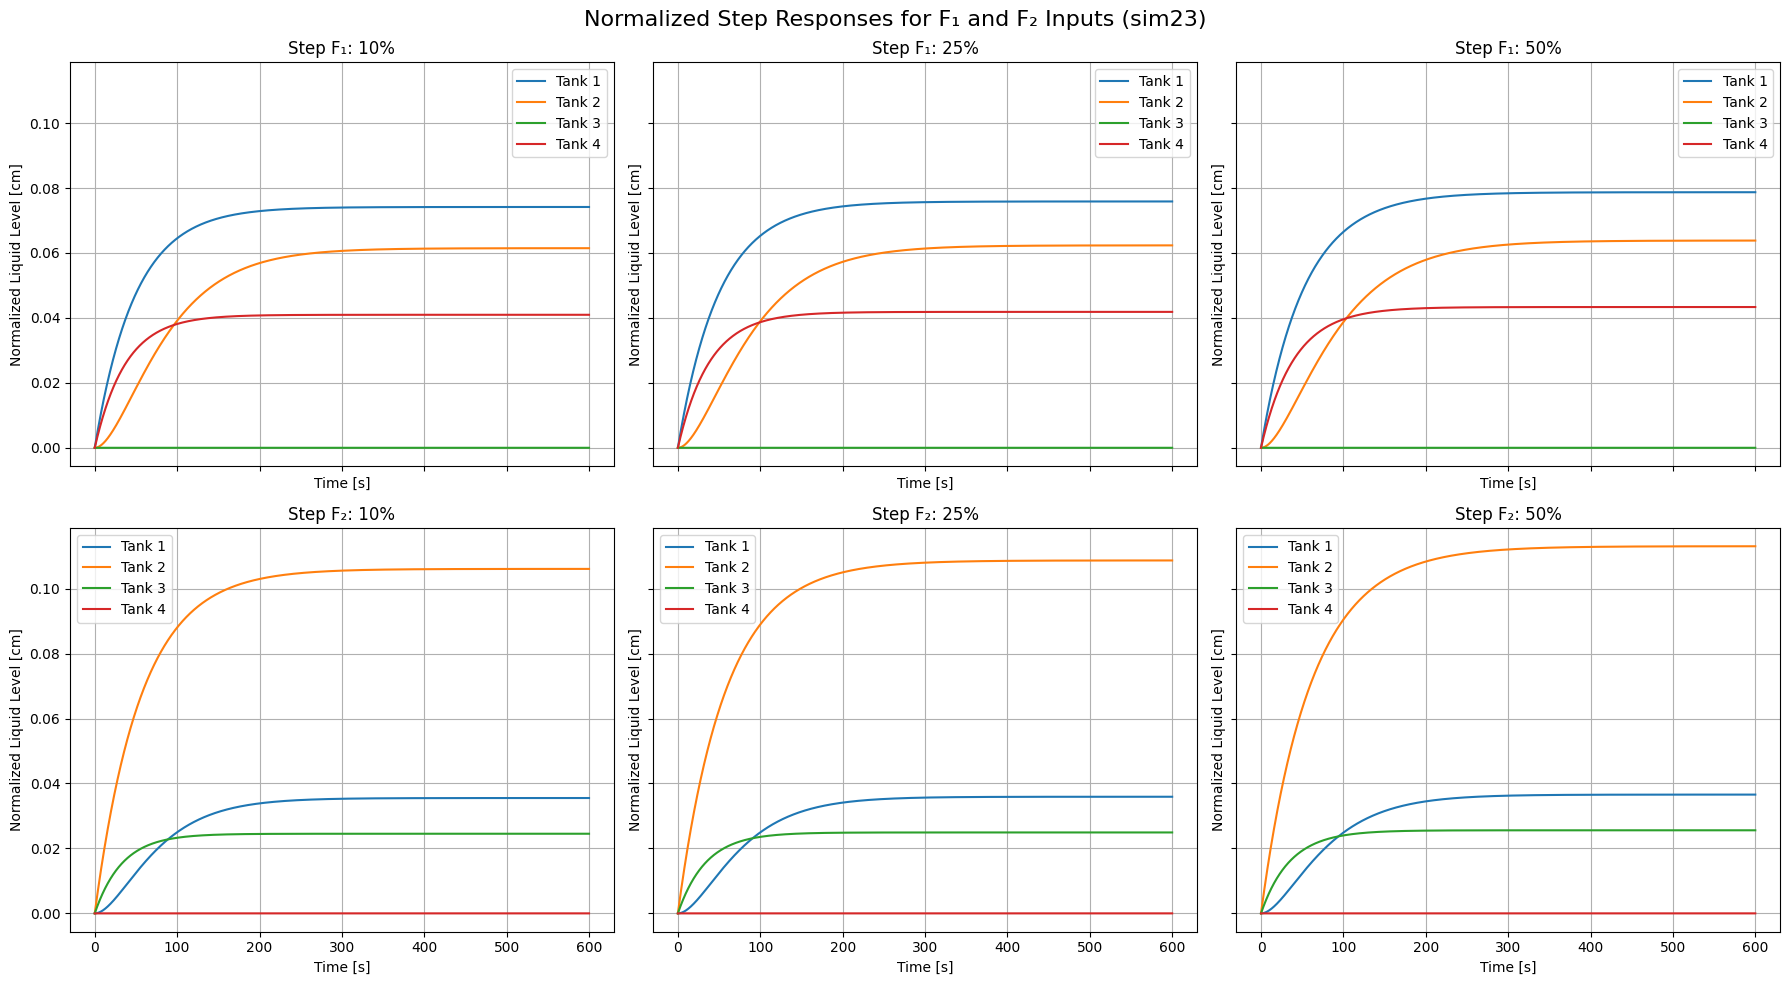

In [7]:
noise_level = 0
dt = 0.01
step_pers_list = [0.1, 0.25, 0.5]

fig, axs = plt.subplots(2, len(step_pers_list), figsize=(18, 10), sharex=True, sharey=True)

F1_info = []
F2_info = []

for idx, step_pers in enumerate(step_pers_list):
    # --- Common setup ---
    F1_base = np.array([100])
    F2_base = np.array([100])
    F3 = np.array([100])
    F4 = np.array([100])
    A = p[4:8]
    rho = p[11]
    times = np.array([0, 10]) * 60
    tf = times[-1]
    t = np.arange(0, tf + dt, dt)

    # --- Steady-state simulation ---
    u_base = np.array([F1_base, F2_base])
    d = np.array([F3, F4])
    x_ss = fun.sim23(times, dt, x0, u_base, d, p, noise_level=noise_level, plot=False)
    x0_ss = x_ss[:, -1].flatten()

    # ============================
    # Simulation: Step in F1 only
    # ============================
    F1 = F1_base * (1 + step_pers)
    F2 = F2_base
    step_size_F1 = float(F1[0] - F1_base[0])
    u = np.array([F1, F2])
    x = fun.sim23(times, dt, x0_ss, u, d, p, noise_level=noise_level, plot=False)
    xend = x[:, -1].flatten()

    for i in range(4):
        xunit = (x[i, :] - x0_ss[i]) / step_size_F1
        h = xunit / (rho * A[i])

        F1_info.append((t, h))
        axs[0, idx].plot(t, h, label=f'Tank {i+1}')

        # If you want to plot the 10% and 90% of any of the curves to get the rise time
        # if i == 3:
        #     h_ss = h[-1]
        #     # add 10% and 90% lines
        #     axs[0, idx].axhline(0.1 * h_ss, color='gray', linestyle='--', linewidth=0.8)
        #     axs[0, idx].axhline(0.9 * h_ss, color='gray', linestyle='--', linewidth=0.8)

    print()
    axs[0, idx].set_title(f'Step F₁: {int(step_pers * 100)}%')
    axs[0, idx].set_xlabel('Time [s]')
    axs[0, idx].grid(True)

    # ============================
    # Simulation: Step in F2 only
    # ============================
    F1 = F1_base
    F2 = F2_base * (1 + step_pers)
    step_size_F2 = float(F2[0] - F2_base[0])
    u = np.array([F1, F2])
    x = fun.sim23(times, dt, x0_ss, u, d, p, noise_level=noise_level, plot=False)
    xend = x[:, -1].flatten()

    for i in range(4):
        xunit = (x[i, :] - x0_ss[i]) / step_size_F2
        h = xunit / (rho * A[i])
        F2_info.append((t, h))
        axs[1, idx].plot(t, h, label=f'Tank {i+1}')

        # If you want to plot the 10% and 90% of any of the curves to get the rise time
        # if i == 3:    
        #     h_ss = h[-1]
        #     axs[1, idx].axhline(0.1 * h_ss, color='gray', linestyle='--', linewidth=0.8)
        #     axs[1, idx].axhline(0.9 * h_ss, color='gray', linestyle='--', linewidth=0.8)
            
    axs[1, idx].set_title(f'Step F₂: {int(step_pers * 100)}%')
    axs[1, idx].set_xlabel('Time [s]')
    axs[1, idx].grid(True)

# --- Final formatting ---
for row in axs:
    for ax in row:
        ax.set_ylabel('Normalized Liquid Level [cm]')
        ax.legend()

fig.suptitle('Normalized Step Responses for F₁ and F₂ Inputs (sim23)', fontsize=16)
plt.tight_layout()
plt.show()


In [8]:
# choose which step block to use: "10%", "25%", or "50%"
SELECT_BLOCK = "10%"   # change to "50%" if we want 50%

_BLOCK_IDX = {"10%": 0, "25%": 1, "50%": 2}[SELECT_BLOCK]
def pick(F_info, tank_number_1to4):
    # F_info is [tanks 1..4] repeated per step size; block size = 4, cuz 4 tanks
    return F_info[_BLOCK_IDX*4 + (tank_number_1to4-1)]


# -------------------- SOME NOTES FOR THE PARAMETER GUESSES ---------------------
# From the graphs, we guess the initial parameters, the rest is done by the curvefit() algorithm

# For a first-order step response:
# Tr (rise-time) = t90 - t10 = T * (ln(0.9) - ln(0.1)) = T * ln(9) ≈ T * 2.2
# => T ≈ Tr / 2.2

# For a second-order (two real poles) step response:
# Tr ≈ time from 10% to 90% of steady state
# A good initial guess is:
# T1 ≈ 0.3 * Tr
# T2 ≈ 1.0 * Tr

# None of the graphs seems to show a time delay or a pole so we set tau and beta to 0

# Use a small T2 for the first order transfer functions (e.g. 1e-3) instead of 0
# → avoids singularities in denominator and keeps the fit numerically stable
# -------------------------------------------------------------------------------


# All of the parameters here are manlually put in by reading of the step responses

channels = [        # guess (K, T1, T2, tau, beta) for 2nd order or (K, T, tau, beta) for 1st order
    ('F1 -> T1', pick(F1_info, 1),   (0.07625, 105/2.2, 0.0, 0.0)),             # 1st-order
    ('F1 -> T2', pick(F1_info, 2),   (0.06255, 160*0.3, 160*1.0, 0.0, 0.0)),    # 2nd-order
    ('F1 -> T3', None,          0),                                             # no connection
    ('F1 -> T4', pick(F1_info, 4),   (0.04206,  89/2.2, 0.0, 0.0)),             # 1st-order
    ('F2 -> T1', pick(F2_info, 1),   (0.03600593, 130*0.3, 130*1.0, 0.0, 0.0)), # 2nd-order
    ('F2 -> T2', pick(F2_info, 2),   (0.10928063, 135/2.2, 0.0, 0.0)),          # 1st-order
    ('F2 -> T3', pick(F2_info, 3),   (0.02501051,  79/2.2, 0.0, 0.0)),          # 1st-order
    ('F2 -> T4', None,          0),                                             # no connection
]

# We store all the transfer functions in a list
SISO_tf = []
fit_params = []  # keep params to inspect/report them
labels = []

speedup = True # Cell takes around 45 seconds to run when speedup = False

for label, curve, guess in channels:
    if (guess == 0) or (curve is None):
        SISO_tf.append(0)
        fit_params.append(None)
        continue
    t_i, s_i = curve  # (time, normalized response)
    g = np.atleast_1d(guess)
    if g.size == 4:   # first order
        tf_i, params_i = fun.fit_channel_foptd(t=t_i, s=s_i, guess=guess, speedup=speedup)
        print('hey')
    elif g.size == 5: # second order
        tf_i, params_i = fun.fit_channel_soptd(t=t_i, s=s_i, guess=guess, speedup=speedup)
    else:
        raise ValueError("Only 4 or 5 parameters are allowed")
    SISO_tf.append(tf_i)
    labels.append(label)
    fit_params.append(params_i)


hey
hey
hey
hey


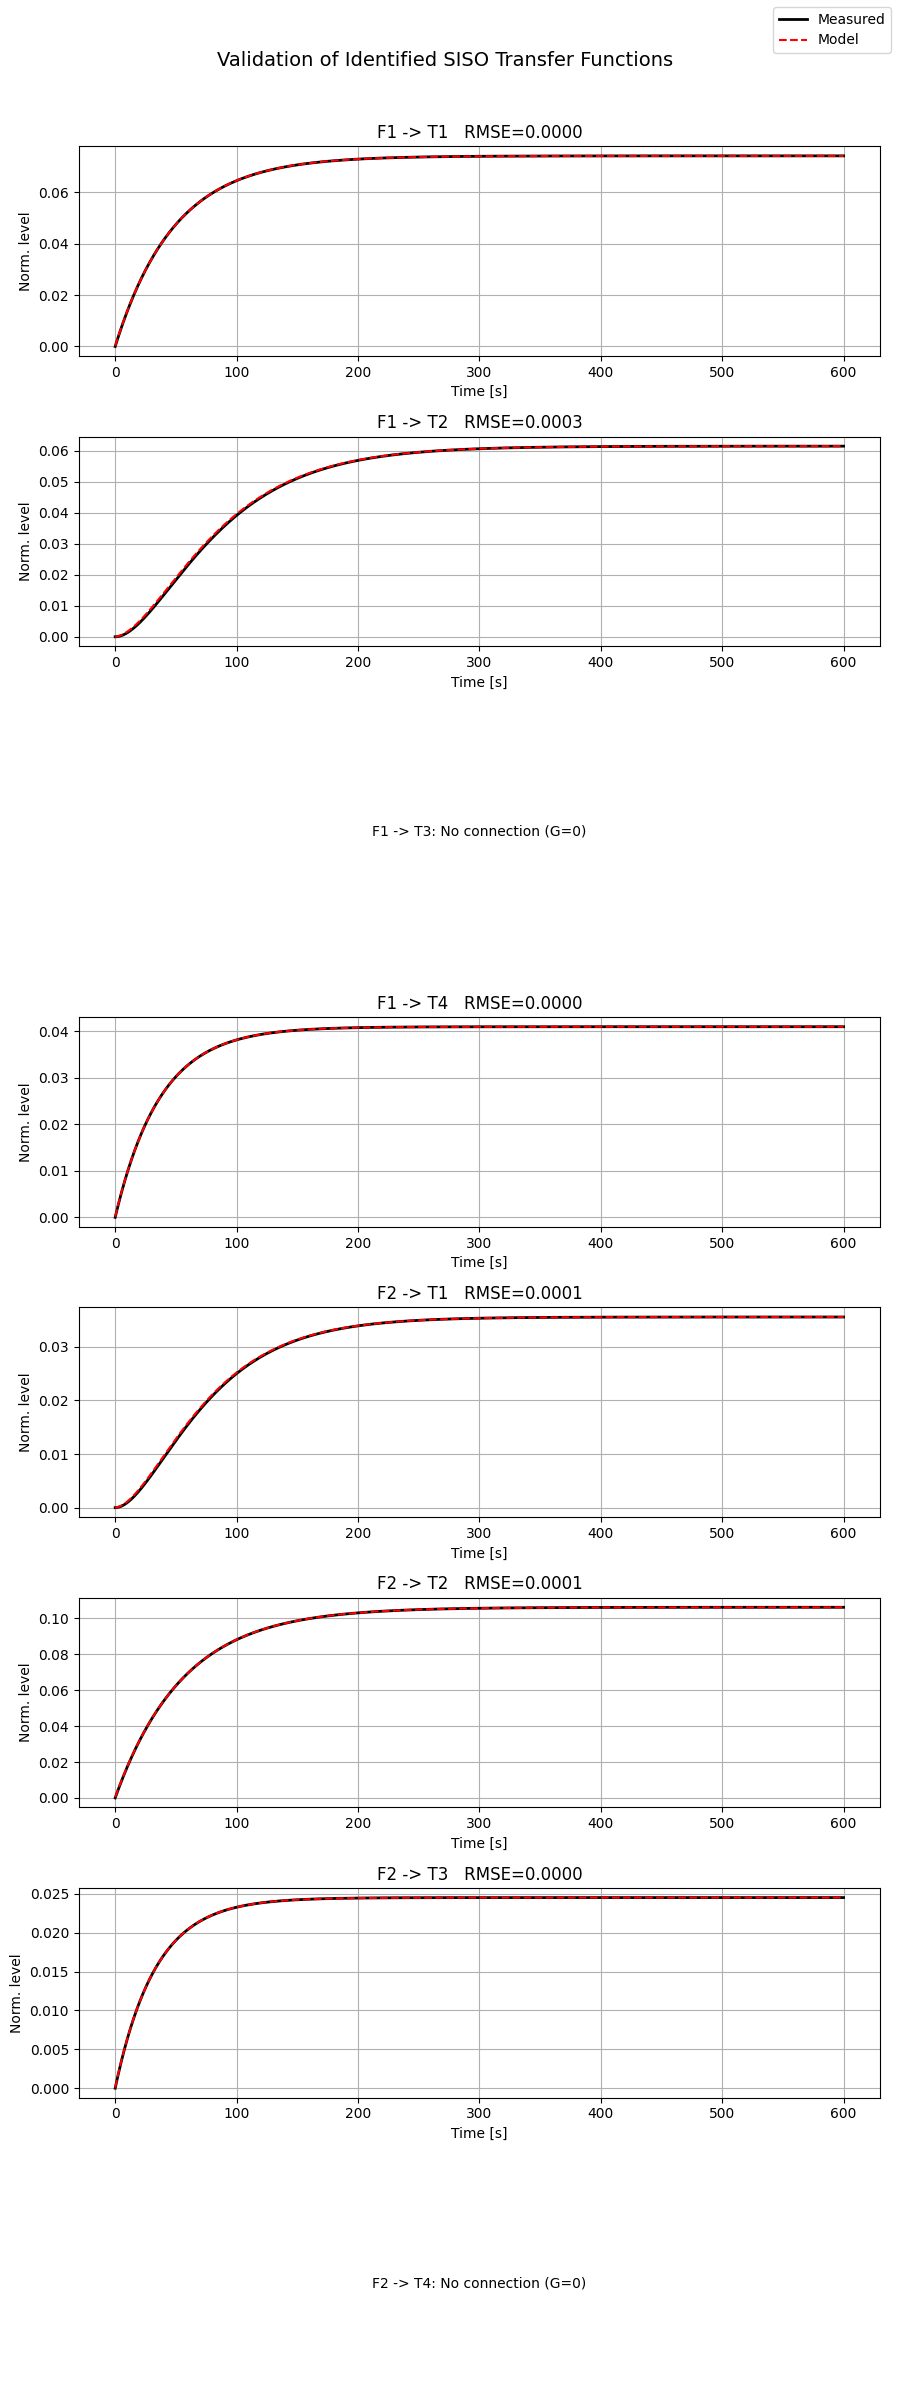

In [9]:
# ------- We validate the transfer functions --------
fig, axs = plt.subplots(len(channels), 1, figsize=(9, 3*len(channels)), sharex=False)

if len(channels) == 1:
    axs = [axs]

for ax, (label, curve, guess), G in zip(axs, channels, SISO_tf):
    if G == 0 or curve is None:
        ax.text(0.5, 0.5, f"{label}: No connection (G=0)", ha='center', va='center')
        ax.set_axis_off()
        continue

    t, s_meas = curve
    y_model = ct.forced_response(G, T=t, U=np.ones_like(t))[1]
    rmse = np.sqrt(np.mean((y_model - s_meas)**2))

    ax.plot(t, s_meas, 'k', lw=2, label='Measured')
    ax.plot(t, y_model, 'r--', label='Model')
    ax.grid(True)
    ax.set_title(f"{label}   RMSE={rmse:.4f}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Norm. level")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Validation of Identified SISO Transfer Functions", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [10]:
# We want the transfer function from F1, F2 to the tank1 and tank2

G11_nom = SISO_tf[0].num
G12_nom = SISO_tf[1].num
G21_nom = SISO_tf[4].num
G22_nom = SISO_tf[5].num

G11_den = SISO_tf[0].den
G12_den = SISO_tf[1].den
G21_den = SISO_tf[4].den
G22_den = SISO_tf[5].den

print('F1 --> tank 1:')
print(f'Num: {G11_nom}')
print(f'Den: {G11_den}')
print()
print('F1 --> tank 2:')
print(f'Num: {G12_nom}')
print(f'Den: {G12_den}')
print()
print('F2 --> tank 1:')
print(f'Num: {G21_nom}')
print(f'Den: {G21_den}')
print()
print('F2 --> tank 2:')
print(f'Num: {G22_nom}')
print(f'Den: {G22_den}')


F1 --> tank 1:
Num: [[array([0.01090119, 0.07415812])]]
Den: [[array([48.99572662,  1.        ])]]

F1 --> tank 2:
Num: [[array([0.09878643, 0.06148198])]]
Den: [[array([2.07053379e+03, 9.32448763e+01, 1.00000000e+00])]]

F2 --> tank 1:
Num: [[array([0.04384073, 0.0355246 ])]]
Den: [[array([1.6107418e+03, 8.1888073e+01, 1.0000000e+00])]]

F2 --> tank 2:
Num: [[array([0.02307903, 0.10607662])]]
Den: [[array([56.47085069,  1.        ])]]


In [11]:
######## INSERT INTO MATLAB CODE FROM LECTURE 5 ########
# Using the mimoctf2dss function he provided and our transfer functions as 
# inputs we get the following parameters

'''
################################ MATLAB CODE ######################################
% This script illustrate creation of a discrete-time state space model
% from a continuous-time MIMO transfer function. It uses the function
% mimoctf2dss. 
clear
clc


%% Create transfer function matrix representation G(s)
%  see slides
num = cell(2,2);
den = cell(2,2);
lambda = zeros(2,2);

% G(1,1)
num(1,1) = {[0.01087883, 0.07415812]}
den(1,1) = {[48.99572662,  1.        ]}
lambda(1,1) = 0

% G(2,1)
num(2,1) = {[0.09878632, 0.06148198]}
den(2,1) = {[2.07053370e+03, 9.32448758e+01, 1.00000000e+00]}
lambda(2,1) = 0

% G(1,2)
num(1,2) = {[0.04384079, 0.0355246 ]}
den(1,2) = {[1.61074177e+03, 8.18880728e+01, 1.00000000e+00]}
lambda(1,2) = 0.0

% G(2,2)
num(2,2) = {[0.02307903, 0.10607662]}
den(2,2) = {[56.47085069,  1.        ]}
lambda(2,2) = 0

%% Create the discrete-time state space model
Ts   = 0.05     % sample time
Nmax = 100      % maximum state dimension is Nmax/2
tol  = 1.0e-8   % tolerance

[Ad,Bd,Cd,Dd,sH] = mimoctf2dss(num,den,lambda,Ts,Nmax,tol);


%% Formatting copy paste firendly output

% Formatting Ad so we can easily copy paste back to python
rows = arrayfun(@(r) sprintf('    [%s]', ...
    strjoin(string(Ad(r,:)), ', ')), 1:size(Ad,1), 'UniformOutput', false);
txt = strjoin(rows, ",\n");
fprintf('Ad = np.array([\n%s\n])\n', txt);

% Formatting Bd so we can easily copy paste back to python
rows = arrayfun(@(r) sprintf('    [%s]', ...
    strjoin(string(Bd(r,:)), ', ')), 1:size(Bd,1), 'UniformOutput', false);
txt = strjoin(rows, ",\n");
fprintf('Bd = np.array([\n%s\n])\n', txt);

% Formatting Cd so we can easily copy paste back to python
rows = arrayfun(@(r) sprintf('    [%s]', ...
    strjoin(string(Cd(r,:)), ', ')), 1:size(Cd,1), 'UniformOutput', false);
txt = strjoin(rows, ",\n");
fprintf('Cd = np.array([\n%s\n])\n', txt);

% Formatting Dd so we can easily copy paste back to python
rows = arrayfun(@(r) sprintf('    [%s]', ...
    strjoin(string(Dd(r,:)), ', ')), 1:size(Dd,1), 'UniformOutput', false);
txt = strjoin(rows, ",\n");
fprintf('Dd = np.array([\n%s\n])\n', txt);


whos 
%%
figure(1)
semilogy(sH,'b.-','linewidth',2,'markersize',30)
'''

######### Output parameters ############

Ad = np.array([
    [0.9994, -0.00071986, -0.00074078, -0.00021108],
    [-0.00049849, 0.99861, 0.00048399, -0.00041481],
    [0.00078623, -0.00038093, 0.99786, 0.00015309],
    [0.00016606, 0.00044032, -0.0001451, 0.99934]
])

Bd = np.array([
    [-0.0022041, -0.0094102],
    [0.0084031, -0.0022275],
    [0.00012289, 0.00016175],
    [-7.8822e-05, 6.008e-05]
])

Cd = np.array([
    [-0.0021414, 0.0084155, -0.00013992, 7.1981e-05],
    [-0.0094243, -0.0021824, -0.00014728, -6.8123e-05]
])

Dd = np.array([
    [0.00022204, 0],
    [0, 0.00040869]
])

## Transfer functions derived from Step responses:

**F₁ → T₁ (1. order)**

$$
G_{1}(s) = \frac{0.01090s + 0.07416}{48.9957s + 1}
$$

**F₁ → T₂ (2. order)**

$$
G_{2}(s) = \frac{0.09879s + 0.06148}{2070.53s^{2} + 93.2449s + 1}
$$

**F₁ → T₃**

$$
G_{3}(s) = 0
$$

**F₁ → T₄ (1. order)**

$$
G_{4}(s) = \frac{0.005109s + 0.04096}{37.3638s + 1}
$$

**F₂ → T₁ (2. order)**

$$
G_{5}(s) = \frac{0.04384s + 0.03552}{1610.74s^{2} + 81.8881s + 1}
$$

**F₂ → T₂ (1. order)**

$$
G_{6}(s) = \frac{0.02308s + 0.10608}{56.4709s + 1}
$$

**F₂ → T₃ (1. order)**

$$
G_{7}(s) = \frac{0.002490s + 0.02452}{33.4847s + 1}
$$

**F₂ → T₄**

$$
G_{8}(s) = 0
$$


# Problem 5
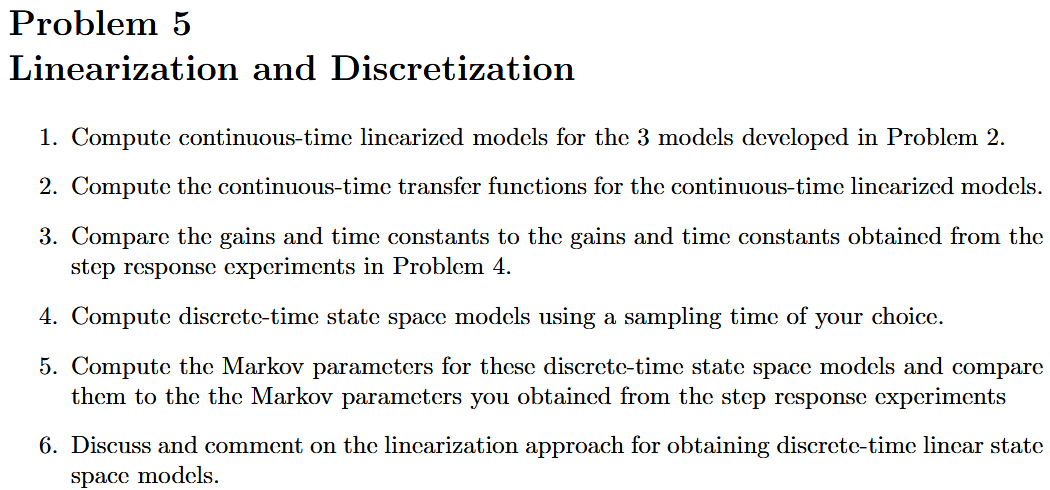

In [12]:
# Compute continuous linearised models

# Problem 7
QP solver interface
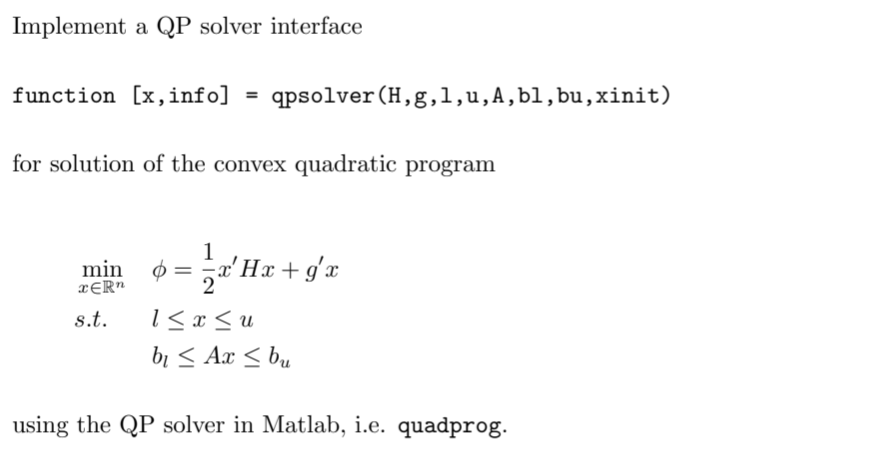

see function qpsolver in the functions document

Polishing not needed - no active set detected at optimal point
(2,)


/Users/balazspeisz/Library/Python/3.14/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/balazspeisz/Library/Python/3.14/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


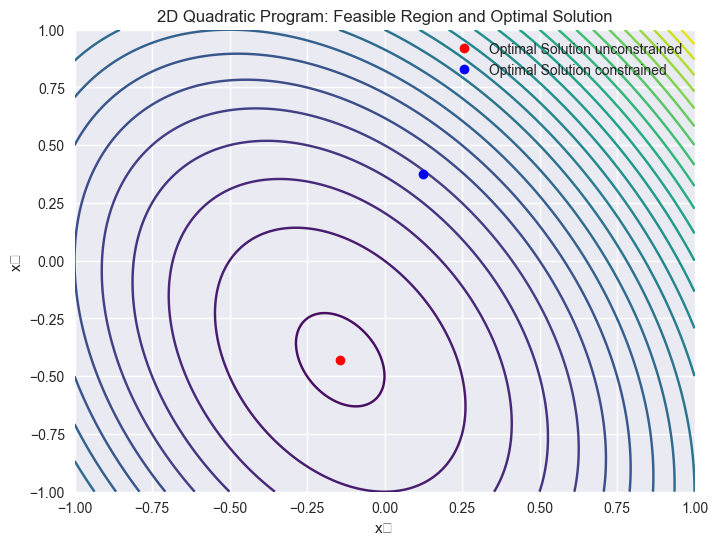

In [13]:
# Example for qp solver unconstrained and constrained
H = np.array([[4, 1], [1, 2]])
g = np.array([1, 1])
l = np.array([0, 0])
u = np.array([1, 1])
A = np.array([[1, 1]])
bl = np.array([0.5])
bu = np.array([1.5])

x, min_val = fun.qpsolver(H, g)
x1, min_val1= fun.qpsolver(H, g, l,u,A,bl,bu)
print(x.shape)
# Create grid for plotting
x1_vals = np.linspace(-1, 1, 200)
x2_vals = np.linspace(-1, 1, 200)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = 0.5 * (H[0,0]*X1**2 + 2*H[0,1]*X1*X2 + H[1,1]*X2**2) + g[0]*X1 + g[1]*X2


# Plotting
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8, 6))
plt.contour(X1, X2, Z, levels=30, cmap='viridis')
plt.contourf(X1, X2, levels=[0.5, 1], colors=['lightgray'], alpha=0.5)
plt.plot(x[0], x[1], 'ro', label='Optimal Solution unconstrained')
plt.plot(x1[0], x1[1], 'bo', label='Optimal Solution constrained')
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.title('2D Quadratic Program: Feasible Region and Optimal Solution')
plt.legend()
plt.grid(True)
plt.show()


# Problem 8 and 9 Simulation (problem 11)

## Unconstrained simulation example

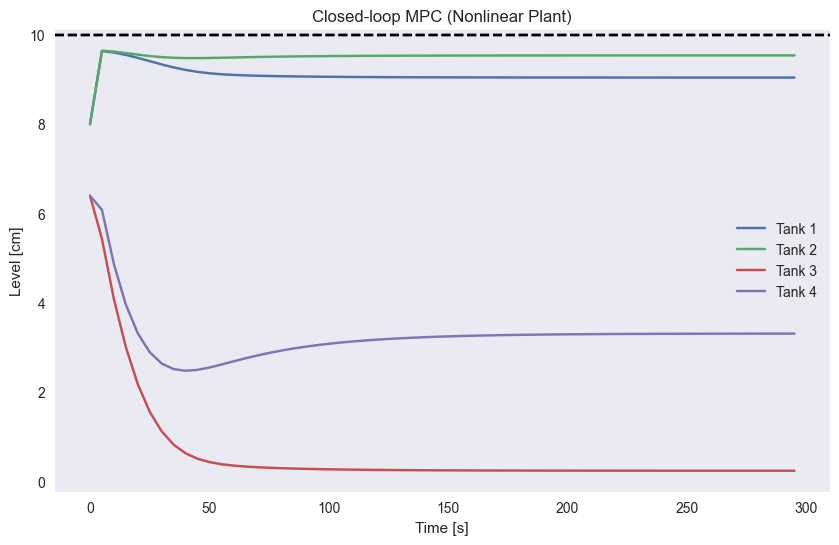

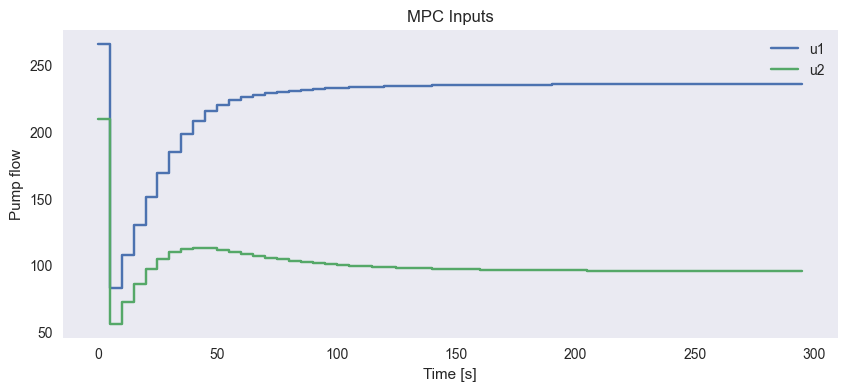

In [14]:
# Desired steady-state tank levels (heights)
h_ref = np.array([10.0, 10.0, 8.0, 8.0])  # cm

# Convert heights → masses
rho = p[11]
A_tank = p[4:8]
x_op = rho * A_tank * h_ref

u_op = fun.compute_steady_state_pump_flow(h_ref, p)
d_op = np.array([0.0, 0.0])  # or nominal F3, F4

# linearize around steady state
Ac, Bc, Bdc, Cc, Dc = fun.linearize_system(
    f=fun.Modified_FourTankSystem,
    g=fun.FourTankSystemSensor_Deterministic,
    x_op=x_op,
    u_op=u_op,
    d_op=d_op,
    p=p
)

Ts = 5.0  # sampling freq (seconds)

# A,B,C,D matrices
sysd, Ad, Bd, Cd, Dd = fun.discretize_system(
    Ac, Bc, Cc, Dc, Ts
)
# time grid
Ts = 5.0
t = np.arange(0, 300, Ts)

# initial condition
x0 = x_op * 0.8   # 20% deviation

# disturbance
d = np.zeros((2, len(t)))

# MPC tuning
Q = np.diag([10, 10, 0, 0])   # focus on tank 1 & 2
R = 0.1 * np.eye(2)
N = 10

mpc = fun.design_mpc(Ad, Bd, Q, R, N)
# run simulation
x_cl, u_cl, y_cl = fun.closed_loop_mpc_sim_unconstrained(
    t=t,
    x0=x0,
    p=p,
    d=d,
    mpc=mpc,
    xr=x_op,
)


## Constrained simulation example

Polishing not needed - no active set detected at optimal point


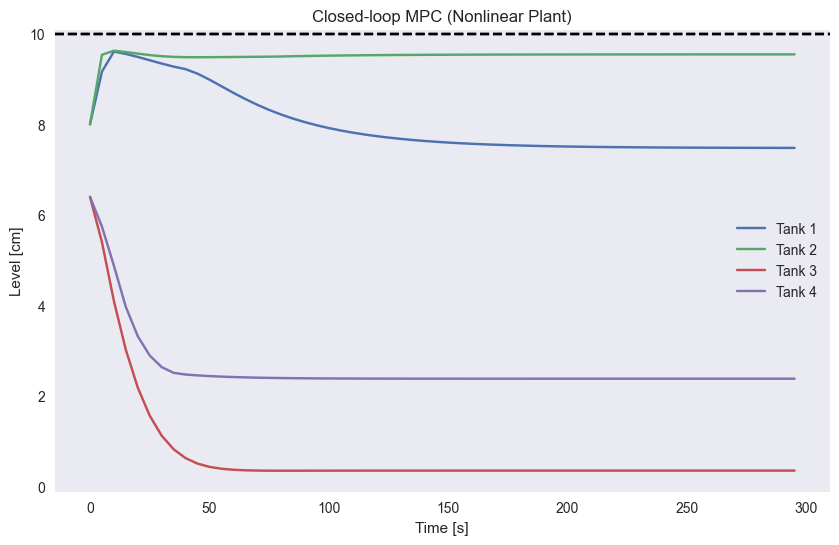

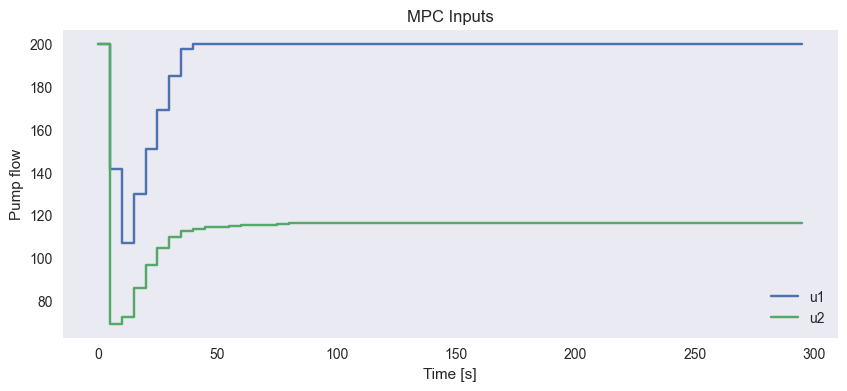

In [15]:
# time grid
Ts = 5.0
t = np.arange(0, 300, Ts)

# initial condition
x0 = x_op * 0.8   # 20% deviation

# disturbance
d = np.zeros((2, len(t)))

# MPC tuning
Q = np.diag([10, 10, 0, 0])   # focus on tank 1 & 2
R = 0.1 * np.eye(2)
N = 10

mpc = fun.design_mpc(Ad, Bd, Q, R, N)
u_min, u_max = 0, 200
# run simulation
x_cl, u_cl, y_cl = fun.closed_loop_mpc_sim_constrained(
    t=t,
    x0=x0,
    p=p,
    d=d,
    mpc=mpc,
    xr=x_op,
    u_min = u_min,
    u_max = u_max
)




# Problem 13: Economic Linear and Nonlinear MPC
# 
This section implements the Economic MPC (EMPC) where the objective is to minimize 
pumping costs rather than tracking a setpoint, subject to safety level constraints.

In [25]:
## 13.1 Economic MPC Setup: Price Profile and Constants
# We define a time-varying sinusoidal electricity price profile to simulate peak hours.

dt_sim = 10         
N_horizon = 30      
total_steps = 150   
sim_time = np.arange(0, total_steps * dt_sim, dt_sim)

# Price Profile: Sinusoidal (High cost in the middle of the day)
prices_all = 1.0 + 0.8 * np.sin(2 * np.pi * sim_time / (total_steps * dt_sim))

h_min_threshold = 10.0 # cm
m_min_constraint = [rho * A1 * h_min_threshold, rho * A2 * h_min_threshold]
u_min, u_max = 0.0, 500.0

In [26]:
## 13.2 Linear Economic MPC with dynamic Kalman filter
# We linearize around a nominal operating point and use the Dynamic Kalman Filter for estimation.

# Setup and Linearization
u_eq = np.array([300, 300]) 
d_eq = np.array([100, 100])
xs_eq = fun.find_equilibrium(fun.Modified_FourTankSystem, np.full(4, 15000.0), u_eq, d_eq, p)
Ac, Bc, Bdc, Cc, _ = fun.linearize_system(fun.Modified_FourTankSystem, fun.FourTankSystemSensor, xs_eq, u_eq, d_eq, p)

B_combined = np.block([Bc, Bdc])
Dc_correct = np.zeros((Cc.shape[0], B_combined.shape[1]))
sysd, Ad, Bd_full, Cd_full, Dd_full = fun.discretize_system(Ac, B_combined, Cc, Dc_correct, dt_sim)

Bu_lin = Bd_full[:, :2]  
Bd_lin = Bd_full[:, 2:]  
Cd_meas = Cd_full[:2, :] 

# Initialize Kalman filter
Q_kf = np.eye(4) * 5
R_kf = np.eye(2) * 0.1
kf_linear = fun.DynamicKalmanFilter(Ad, Bu_lin, Cd_meas, np.eye(4), Q_kf, R_kf, np.zeros((4,2)), np.eye(4), xs_eq)

In [27]:
# Simulation loop
x_plant = xs_eq.copy()
history_m_lin = []
history_u_lin = []

print("Running Soft Linear Economic MPC...")
for k in range(total_steps):
    k_end = min(k + N_horizon, total_steps)
    price_hor = prices_all[k:k_end]
    if len(price_hor) < N_horizon: 
        price_hor = np.append(price_hor, np.full(N_horizon - len(price_hor), price_hor[-1]))
    price_matrix = np.tile(price_hor, (2, 1))

    # Measurement + KF Update
    y_k = fun.FourTankSystemSensor(x_plant, p, sigma=np.array([0.1, 0.1, 0.1, 0.1]))[:2]
    u_prev = history_u_lin[-1] if k > 0 else u_eq
    x_hat = kf_linear.one_step(u_prev, y_k).flatten()
    
    # Solve Soft Linear EMPC
    u_opt = fun.solve_soft_linear_economic_mpc(x_hat, Ad, Bu_lin, Bd_lin, d_eq, N_horizon, price_matrix, u_min, u_max, m_min_constraint)
    
    # Apply to Nonlinear Plant
    _, sol_X, _, _ = fun.run_step(x_plant, (0, dt_sim), u_opt, d_eq, p)
    x_plant = sol_X[-1, :]
    history_m_lin.append(x_plant); history_u_lin.append(u_opt)

Running Soft Linear Economic MPC...


In [28]:
## 13.2 Nonlinear Economic MPC with Extended Kalman filter
opti_n, X0_param, Prices_param, Dist_param, U_var, X_var = fun.setup_nempc(p, dt_sim, N_horizon, h_min_threshold)

ekf_nonlinear = fun.ExtendedKalmanFilter(
    fun.Modified_FourTankSystem, 
    fun.FourTankSystemSensor_Deterministic, 
    p, Q_kf, R_kf, xs_eq, np.eye(4), dt_sim
)

x_plant_n = xs_eq.copy()
history_m_non = []
history_u_non = []

print(f"{'Step':<6} | {'Status':<25} | {'u1':<8} | {'u2':<8} | {'Cost':<10}")
print("-" * 70)

# Simulation loop
for k in range(total_steps):
    # Prepare price horizon
    k_end = min(k + N_horizon, total_steps)
    price_hor = prices_all[k:k_end]
    if len(price_hor) < N_horizon: 
        price_hor = np.append(price_hor, np.full(N_horizon - len(price_hor), price_hor[-1]))
    price_matrix = np.tile(price_hor, (2, 1))

    # Measurement + EKF Update
    y_k = fun.FourTankSystemSensor(x_plant_n, p, sigma=np.array([0.1, 0.1, 0.1, 0.1]))[:2]
    u_prev = history_u_non[-1] if k > 0 else u_eq
    u_prev = np.array(u_prev).flatten()
    
    x_hat_n = ekf_nonlinear.one_step(u_prev, d_eq, y_k).flatten()
    
    # Update Solver Parameters
    opti_n.set_value(X0_param, x_hat_n)
    opti_n.set_value(Prices_param, price_matrix)
    opti_n.set_value(Dist_param, d_eq)
    
    # Warm Start Trajectories
    u_init = np.tile(u_prev.reshape(2, 1), (1, N_horizon))
    opti_n.set_initial(U_var, u_init)
    x_init = np.tile(x_hat_n.reshape(4, 1), (1, N_horizon + 1))
    opti_n.set_initial(X_var, x_init)
    
    current_status = "Unknown"
    try:
        sol = opti_n.solve()
        u_opt_n = sol.value(U_var)[:, 0]
        current_status = "Success"
        
        # Advance the warm start for the next iteration
        opti_n.set_initial(U_var, sol.value(U_var))
        opti_n.set_initial(X_var, sol.value(X_var))
        
    except Exception:
        current_status = opti_n.debug.return_status()
        u_opt_n = u_prev # Fallback

    # Logging logic: Print every 10 steps or if the solver fails
    if k % 10 == 0 or current_status != "Success":
        step_cost = np.sum(u_opt_n * price_matrix[:, 0])
        print(f"{k:<6} | {current_status:<25} | {u_opt_n[0]:<8.2f} | {u_opt_n[1]:<8.2f} | {step_cost:<10.2f}")

    # 3. Apply to Nonlinear Plant
    _, sol_X_n, _, _ = fun.run_step(x_plant_n, (0, dt_sim), u_opt_n, d_eq, p)
    x_plant_n = sol_X_n[-1, :]
    
    history_m_non.append(x_plant_n)
    history_u_non.append(u_opt_n)

# Final conversion
history_m_non = np.array(history_m_non)
history_u_non = np.array(history_u_non)

print("-" * 70)
print("Simulation Complete.")

Step   | Status                    | u1       | u2       | Cost      
----------------------------------------------------------------------
0      | Success                   | 0.00     | 0.00     | 0.00      
10     | Success                   | 120.32   | 0.00     | 159.47    
20     | Success                   | 107.16   | 36.48    | 229.04    
30     | Success                   | 105.79   | 37.92    | 253.05    
40     | Success                   | 105.54   | 38.27    | 258.23    
50     | Success                   | 105.46   | 38.33    | 243.41    
60     | Success                   | 105.43   | 38.34    | 211.38    
70     | Success                   | 105.47   | 38.35    | 167.74    
80     | Success                   | 105.44   | 38.34    | 119.87    
90     | Success                   | 105.44   | 38.35    | 76.18     
100    | Success                   | 105.45   | 38.34    | 44.17     
110    | Success                   | 105.45   | 38.36    | 29.39     
120    | Success   

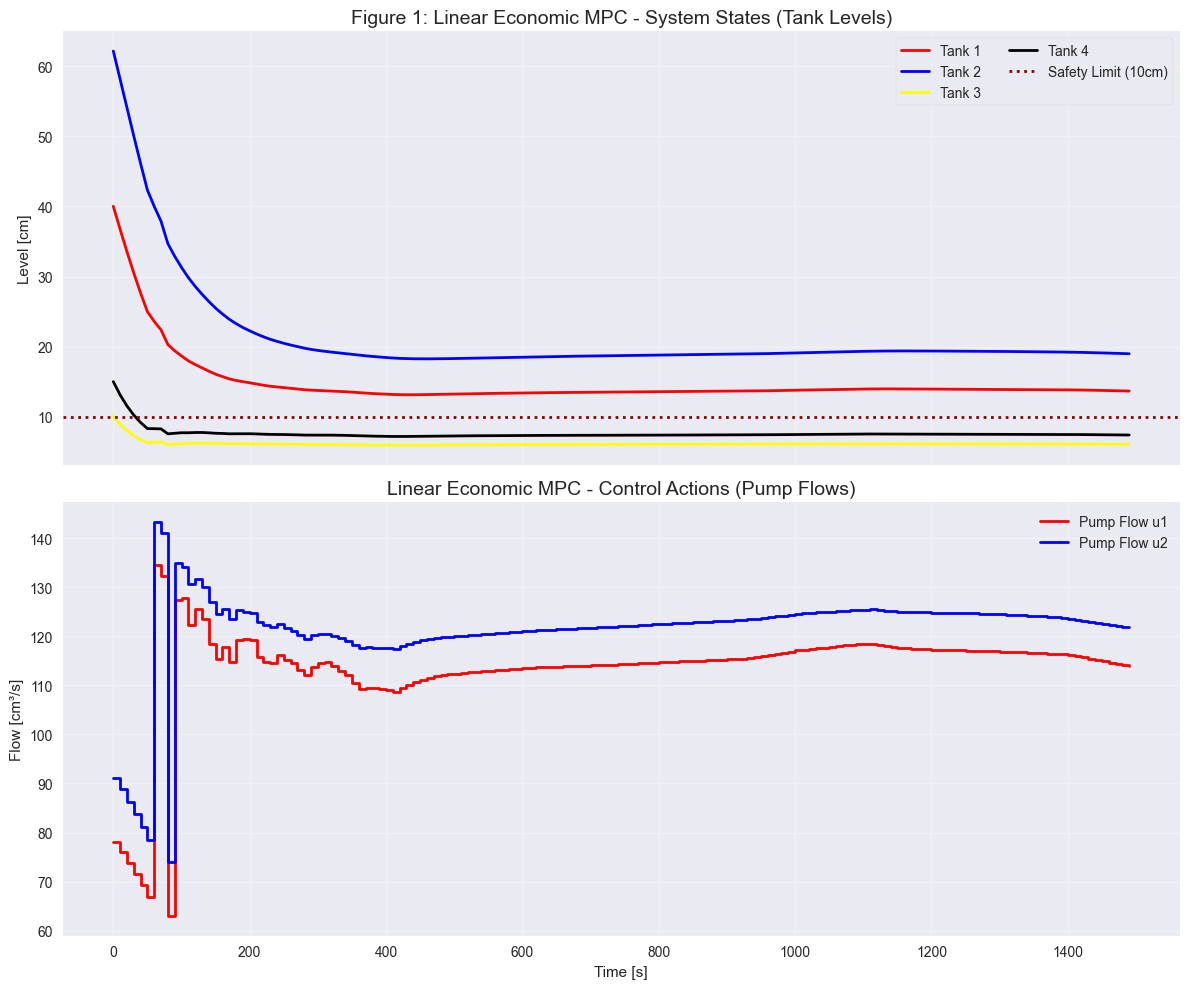

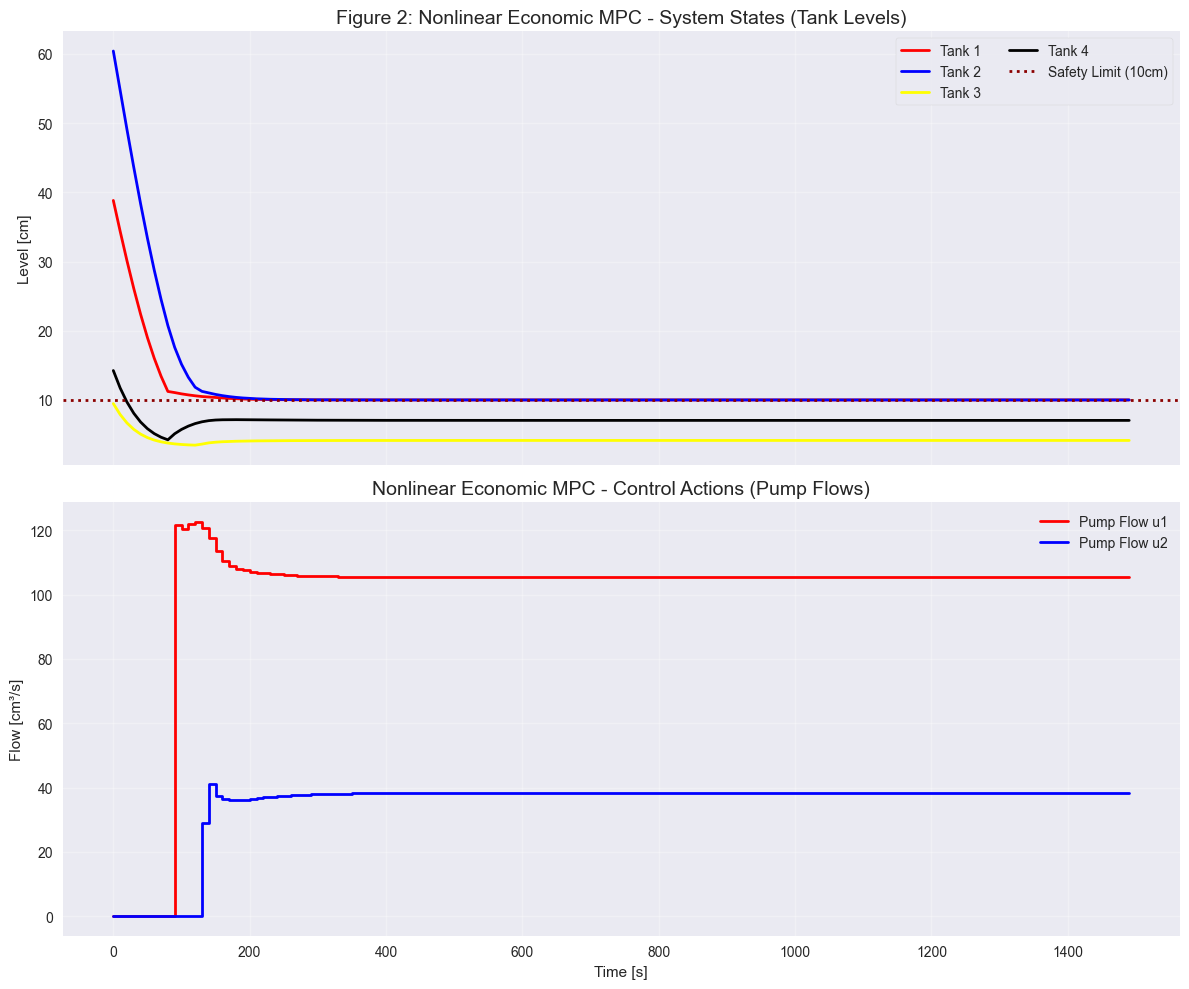

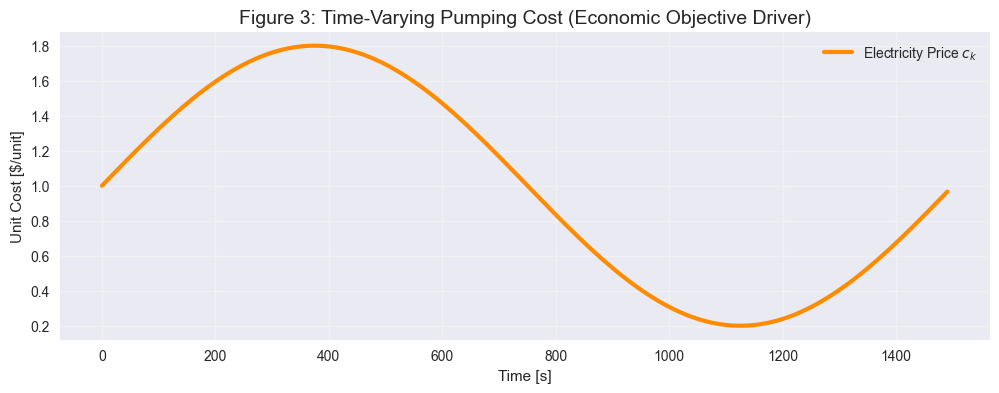

In [29]:

# Data Preparation and Unit Conversion
A_tanks = p[4:8]
h_lin = np.array(history_m_lin) / (rho * A_tanks)
h_non = np.array(history_m_non) / (rho * A_tanks)
u_lin = np.array(history_u_lin)
u_non = np.array(history_u_non)

# Tank 1: Red, Tank 2: Blue, Tank 3: Yellow, Tank 4: Black
tank_colors = ['red', 'blue', 'yellow', 'black']
pump_colors = ['red', 'blue'] # Matching u1 to T1 and u2 to T2 for logic consistency

# Figure 1: LEMPC
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# States (Levels)
for i in range(4):
    ax1.plot(sim_time, h_lin[:, i], color=tank_colors[i], lw=2, label=f'Tank {i+1}')
ax1.axhline(h_min_threshold, color='darkred', linestyle=':', lw=2, label='Safety Limit (10cm)')
ax1.set_ylabel('Level [cm]')
ax1.set_title('Figure 1: Linear Economic MPC - System States (Tank Levels)', fontsize=14)
ax1.legend(loc='upper right', ncol=2, frameon=True)
ax1.grid(True, alpha=0.3)

# Controls (Pumps)
for i in range(2):
    ax2.step(sim_time, u_lin[:, i], color=pump_colors[i], where='post', lw=2, label=f'Pump Flow u{i+1}')
ax2.set_ylabel('Flow [cm³/s]')
ax2.set_xlabel('Time [s]')
ax2.set_title('Linear Economic MPC - Control Actions (Pump Flows)', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Figure 2: NEMPC
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# States (Levels)
for i in range(4):
    ax3.plot(sim_time, h_non[:, i], color=tank_colors[i], lw=2, label=f'Tank {i+1}')
ax3.axhline(h_min_threshold, color='darkred', linestyle=':', lw=2, label='Safety Limit (10cm)')
ax3.set_ylabel('Level [cm]')
ax3.set_title('Figure 2: Nonlinear Economic MPC - System States (Tank Levels)', fontsize=14)
ax3.legend(loc='upper right', ncol=2, frameon=True)
ax3.grid(True, alpha=0.3)

# Controls (Pumps)
for i in range(2):
    ax4.step(sim_time, u_non[:, i], color=pump_colors[i], where='post', lw=2, label=f'Pump Flow u{i+1}')
ax4.set_ylabel('Flow [cm³/s]')
ax4.set_xlabel('Time [s]')
ax4.set_title('Nonlinear Economic MPC - Control Actions (Pump Flows)', fontsize=14)
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Figure 3: Underlying economic assumption
plt.figure(figsize=(12, 4))
plt.plot(sim_time, prices_all, color='darkorange', lw=3, label='Electricity Price $c_k$')
plt.ylabel('Unit Cost [$/unit]')
plt.xlabel('Time [s]')
plt.title('Figure 3: Time-Varying Pumping Cost (Economic Objective Driver)', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
# Performance evaluation

history_m_lin_arr = np.array(history_m_lin)
history_u_lin_arr = np.array(history_u_lin)
history_m_non_arr = np.array(history_m_non)
history_u_non_arr = np.array(history_u_non)

# Calculate Cumulative Pumping Costs
total_cost_lin = np.sum(np.sum(history_u_lin_arr, axis=1) * prices_all)
total_cost_non = np.sum(np.sum(history_u_non_arr, axis=1) * prices_all)

# Extract Final States (Masses)
m_final_lin = history_m_lin_arr[-1, :]
m_final_non = history_m_non_arr[-1, :]

# Convert Final Masses to Heights [cm]
A_tanks = p[4:8]  # A1, A2, A3, A4
h_final_lin = m_final_lin / (rho * A_tanks)
h_final_non = m_final_non / (rho * A_tanks)

# Results table
print("="*55)
print(f"{'Metric':<30} | {'Linear Economic MPC':<10} | {'Nonlinear Economic MPC':<10}")
print("-"*55)
print(f"{'Total Economic Cost ($)':<30} | {total_cost_lin:<10.2f} | {total_cost_non:<10.2f}")
print("-"*55)
for i in range(4):
    print(f"{f'Final Tank {i+1} Level (cm)':<30} | {h_final_lin[i]:<10.2f} | {h_final_non[i]:<10.2f}")
print("="*55)

# Calculate Percentage Savings
savings = (1 - (total_cost_non / total_cost_lin)) * 100
print(f"Nonlinear MPC is {savings:.2f}% more cost-efficient than Linear MPC.")

Metric                         | Linear Economic MPC | Nonlinear Economic MPC
-------------------------------------------------------
Total Economic Cost ($)        | 34924.80   | 20028.64  
-------------------------------------------------------
Final Tank 1 Level (cm)        | 13.70      | 10.00     
Final Tank 2 Level (cm)        | 19.01      | 10.00     
Final Tank 3 Level (cm)        | 6.10       | 4.15      
Final Tank 4 Level (cm)        | 7.43       | 7.05      
Nonlinear MPC is 42.65% more cost-efficient than Linear MPC.
